In [ ]:
# dependencies
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from torchvision import transforms, models
from PIL import Image
import glob

In [ ]:
import os
import kagglehub

# Path to the mounted dataset
kaggle_path = "/kaggle/input/skin-cancer-mnist-ham10000"

if os.path.exists(kaggle_path):
    print(f"Dataset already available at {kaggle_path}.")
else:
    print("Dataset not found, downloading...")
    kaggle_path = kagglehub.dataset_download("kmader/skin-cancer-mnist-ham10000")
    print(f"Downloaded dataset to {kaggle_path}.")

Dataset not found, downloading...
Using Colab cache for faster access to the 'skin-cancer-mnist-ham10000' dataset.
Downloaded dataset to /kaggle/input/skin-cancer-mnist-ham10000.


In [ ]:
import kagglehub
from kagglehub import KaggleDatasetAdapter
import pandas as pd

metadata_path = "HAM10000_metadata.csv"
df = kagglehub.dataset_load(
    KaggleDatasetAdapter.PANDAS,
    "kmader/skin-cancer-mnist-ham10000",
    metadata_path
)

print(df.shape)
df.head()

Using Colab cache for faster access to the 'skin-cancer-mnist-ham10000' dataset.
(10015, 7)


,lesion_id,image_id,dx,dx_type,age,sex,localization
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear


In [ ]:
image_dirs = [
    "/kaggle/input/skin-cancer-mnist-ham10000/HAM10000_images_part_1",
    "/kaggle/input/skin-cancer-mnist-ham10000/HAM10000_images_part_2"
]

all_files = []
for d in image_dirs:
    all_files += glob.glob(os.path.join(d, "*.jpg"))

id_to_path = {os.path.splitext(os.path.basename(p))[0]: p for p in all_files}

df["path"] = df["image_id"].map(id_to_path)
df = df.dropna(subset=["path"]).reset_index(drop=True)

classes = sorted(df["dx"].unique())
class_to_idx = {c: i for i, c in enumerate(classes)}
idx_to_class = {i: c for c, i in class_to_idx.items()}
df["y"] = df["dx"].map(class_to_idx).astype(np.int32)

K = len(classes)

In [ ]:
from sklearn.model_selection import GroupShuffleSplit
# lesion-wise split (prevents leakage)
# first split: train vs test (20% test)
gss = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
train_idx, test_idx = next(gss.split(df, df["y"], groups=df["lesion_id"]))
train_df, test_df = df.iloc[train_idx].copy(), df.iloc[test_idx].copy()

# Second split: train vs val (val ~10% of total)
# 0.1111 of remaining 80% ≈ 8.888% -> close to ~10% of total when grouped
gss2 = GroupShuffleSplit(n_splits=1, test_size=0.1111, random_state=42)
train_idx2, val_idx = next(gss2.split(train_df, train_df["y"], groups=train_df["lesion_id"]))
train_df, val_df = train_df.iloc[train_idx2].copy(), train_df.iloc[val_idx].copy()

print("Split sizes:", len(train_df), len(val_df), len(test_df))


Split sizes: 7121 870 2024


In [ ]:
import cv2
import tensorflow as tf

def preprocess_opencv(rgb_uint8,
                      grad_low=15, grad_high=80,   #  tune these
                      sigma=2.0):
    img = rgb_uint8.copy()

    # HSV gradient exclusion (value channel)
    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    v = hsv[:, :, 2].astype(np.float32)

    gx = cv2.Sobel(v, cv2.CV_32F, 1, 0, ksize=3)
    gy = cv2.Sobel(v, cv2.CV_32F, 0, 1, ksize=3)
    grad = cv2.magnitude(gx, gy)

    # mask gradients in a chosen range; suppress them by smoothing V locally
    mask = (grad >= grad_low) & (grad <= grad_high)
    v_smooth = cv2.GaussianBlur(v, (0, 0), sigmaX=1.0)
    v[mask] = v_smooth[mask]
    hsv[:, :, 2] = np.clip(v, 0, 255).astype(np.uint8)
    img = cv2.cvtColor(hsv, cv2.COLOR_HSV2RGB)

    # k-means (k=2) to extract lesion region
    lab = cv2.cvtColor(img, cv2.COLOR_RGB2LAB)
    Z = lab.reshape(-1, 3).astype(np.float32)

    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 1.0)
    _, labels, centers = cv2.kmeans(Z, 2, None, criteria, 5, cv2.KMEANS_PP_CENTERS)
    labels = labels.reshape(lab.shape[:2])

    # heuristic: lesion tends to be "darker" in L channel
    centers_lab = centers.astype(np.float32)
    lesion_cluster = int(np.argmin(centers_lab[:, 0]))
    lesion_mask = (labels == lesion_cluster).astype(np.float32)

    # smooth the mask (Gaussian filtering with sigma=2)
    lesion_mask = cv2.GaussianBlur(lesion_mask, (0, 0), sigmaX=sigma)
    lesion_mask = np.clip(lesion_mask, 0.0, 1.0)

    # disregard texture of normal skin by smoothing background
    blurred = cv2.GaussianBlur(img, (0, 0), sigmaX=sigma)
    out = (img * lesion_mask[..., None] + blurred * (1 - lesion_mask[..., None])).astype(np.uint8)
    return out


In [ ]:
# tf.data load function with OpenCV preprocessing injected

IMG_SIZE = 224
def load_image(path, label):
    img_bytes = tf.io.read_file(path)
    img = tf.image.decode_jpeg(img_bytes, channels=3)
    img = tf.image.resize(img, [IMG_SIZE, IMG_SIZE])
    img = tf.cast(img, tf.uint8)

    def _cv2_fn(x):
        x = x.numpy()
        y = preprocess_opencv(x, grad_low=15, grad_high=80, sigma=2.0)
        return y

    img = tf.py_function(_cv2_fn, [img], Tout=tf.uint8)
    img.set_shape([IMG_SIZE, IMG_SIZE, 3])
    img = tf.cast(img, tf.float32)
    return img, label


In [ ]:
# data augmentation: rotations + flips
augment = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.05),
    tf.keras.layers.RandomZoom(0.10),
    tf.keras.layers.RandomContrast(0.10),
])


In [ ]:
# dataset builder
BATCH = 32
AUTOTUNE = tf.data.AUTOTUNE

def make_ds(dframe, training=False):
    paths = dframe["path"].values
    labels = dframe["y"].values

    ds = tf.data.Dataset.from_tensor_slices((paths, labels))
    if training:
        ds = ds.shuffle(2048, reshuffle_each_iteration=True)

    ds = ds.map(load_image, num_parallel_calls=AUTOTUNE)

    if training:
        ds = ds.map(lambda x, y: (augment(x, training=True), y), num_parallel_calls=AUTOTUNE)

    ds = ds.batch(BATCH).prefetch(AUTOTUNE)
    return ds

train_ds = make_ds(train_df, training=True)
val_ds   = make_ds(val_df, training=False)
test_ds  = make_ds(test_df, training=False)




In [ ]:
# sanity-check: shapes + label distribution in one batch
x_batch, y_batch = next(iter(train_ds))
print("x:", x_batch.shape, x_batch.dtype)
print("y:", y_batch.shape, y_batch.dtype)
print("unique labels in batch:", np.unique(y_batch.numpy()))


x: (32, 224, 224, 3) <dtype: 'float32'>
y: (32,) <dtype: 'int32'>
unique labels in batch: [1 2 3 4 6]


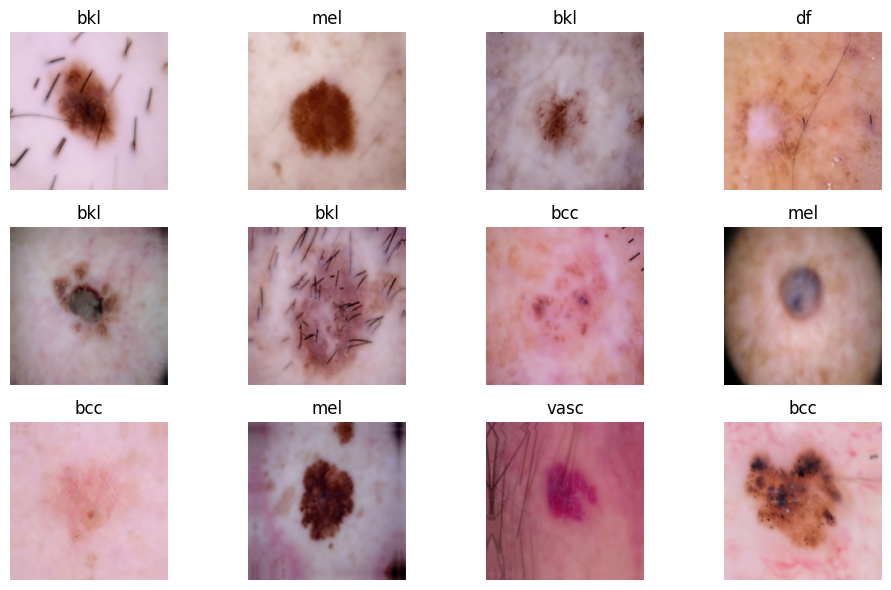

In [ ]:
# sanity-check: visualize a few samples (to make sure augment/preprocess looks reasonable)
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
for i in range(12):
    plt.subplot(3, 4, i + 1)
    img = x_batch[i].numpy().astype(np.uint8)
    plt.imshow(img)
    plt.title(classes[int(y_batch[i])])
    plt.axis("off")
plt.tight_layout()
plt.show()


In [ ]:
# build the ResNet50 baseline model
preprocess = tf.keras.applications.resnet.preprocess_input

base = tf.keras.applications.ResNet50(
    include_top=False,
    weights="imagenet",
    input_shape=(IMG_SIZE, IMG_SIZE, 3),
)
base.trainable = False

inputs = tf.keras.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
x = preprocess(inputs)
x = base(x, training=False)
feat = tf.keras.layers.GlobalAveragePooling2D(name="feat")(x)
x = tf.keras.layers.Dropout(0.3)(feat)
outputs = tf.keras.layers.Dense(K, activation="softmax", name="pred")(x)

model = tf.keras.Model(inputs, outputs)

model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-3),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=[tf.keras.metrics.SparseCategoricalAccuracy(name="acc")]
)


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
# train (baseline)
callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True, monitor="val_loss"),
    tf.keras.callbacks.ReduceLROnPlateau(patience=2, factor=0.5, monitor="val_loss"),
]

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=20,
    callbacks=callbacks
)


Epoch 1/20
223/223 ━━━━━━━━━━━━━━━━━━━━ 490s 2s/step - acc: 0.6119 - loss: 1.1855 - val_acc: 0.7207 - val_loss: 0.8435 - learning_rate: 0.0010
Epoch 2/20
223/223 ━━━━━━━━━━━━━━━━━━━━ 418s 2s/step - acc: 0.6927 - loss: 0.9068 - val_acc: 0.7425 - val_loss: 0.7758 - learning_rate: 0.0010
Epoch 3/20
223/223 ━━━━━━━━━━━━━━━━━━━━ 411s 2s/step - acc: 0.7114 - loss: 0.8396 - val_acc: 0.7575 - val_loss: 0.7506 - learning_rate: 0.0010
Epoch 4/20
223/223 ━━━━━━━━━━━━━━━━━━━━ 409s 2s/step - acc: 0.7277 - loss: 0.7752 - val_acc: 0.7425 - val_loss: 0.8895 - learning_rate: 0.0010
Epoch 5/20
223/223 ━━━━━━━━━━━━━━━━━━━━ 400s 2s/step - acc: 0.7282 - loss: 0.7548 - val_acc: 0.7759 - val_loss: 0.7387 - learning_rate: 0.0010
Epoch 6/20
223/223 ━━━━━━━━━━━━━━━━━━━━ 405s 2s/step - acc: 0.7577 - loss: 0.7374 - val_acc: 0.7644 - val_loss: 0.7188 - learning_rate: 0.0010
Epoch 7/20
223/223 ━━━━━━━━━━━━━━━━━━━━ 427s 2s/step - acc: 0.7552 - loss: 0.6991 - val_acc: 0.7586 - val_loss: 0.7227 - learning_rate: 0.0010

In [ ]:
train_ds_noaug = make_ds(train_df, training=False)
val_ds_noaug   = make_ds(val_df, training=False)
test_ds_noaug  = make_ds(test_df, training=False)

In [ ]:
feat_extractor = tf.keras.Model(
    inputs=model.input,
    outputs=model.get_layer("feat").output
)

In [ ]:
def extract_features(ds, feat_model):
    X_list, y_list = [], []
    for xb, yb in ds:
        fb = feat_model(xb, training=False).numpy()
        X_list.append(fb)
        y_list.append(yb.numpy())
    X = np.concatenate(X_list, axis=0)
    y = np.concatenate(y_list, axis=0)
    return X, y

Phi_train, y_train = extract_features(train_ds_noaug, feat_extractor)
Phi_val,   y_val   = extract_features(val_ds_noaug, feat_extractor)
Phi_test,  y_test  = extract_features(test_ds_noaug, feat_extractor)


In [ ]:
def correlation_feature_filter(Phi, tau=0.7):
    C = np.corrcoef(Phi, rowvar=False)
    absC = np.abs(C)
    var = Phi.var(axis=0)

    d = Phi.shape[1]
    to_drop = np.zeros(d, dtype=bool)

    for j in range(d):
        if to_drop[j]:
            continue
        ks = np.where(absC[j, j+1:] > tau)[0] + (j + 1)
        for k in ks:
            if to_drop[k]:
                continue
            drop = j if var[j] < var[k] else k
            to_drop[drop] = True
            if drop == j:
                break

    return np.where(~to_drop)[0]

tau = 0.7
keep_idx = correlation_feature_filter(Phi_train, tau=tau)

Phi_train_f = Phi_train[:, keep_idx]
Phi_val_f   = Phi_val[:, keep_idx]
Phi_test_f  = Phi_test[:, keep_idx]

print("d -> d':", Phi_train.shape[1], "->", Phi_train_f.shape[1])

d -> d': 2048 -> 1956


In [ ]:
clf = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(Phi_train_f.shape[1],)),
    tf.keras.layers.Dense(256, activation="relu"),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(K, activation="softmax")
])

clf.compile(
    optimizer=tf.keras.optimizers.Adam(1e-3),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=[tf.keras.metrics.SparseCategoricalAccuracy(name="acc")]
)

callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True, monitor="val_loss"),
    tf.keras.callbacks.ReduceLROnPlateau(patience=2, factor=0.5, monitor="val_loss"),
]

history_clf = clf.fit(
    Phi_train_f, y_train,
    validation_data=(Phi_val_f, y_val),
    epochs=30,
    batch_size=32,
    callbacks=callbacks
)


Epoch 1/30
223/223 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - acc: 0.6758 - loss: 1.0315 - val_acc: 0.7494 - val_loss: 0.6581 - learning_rate: 0.0010
Epoch 2/30
223/223 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - acc: 0.7634 - loss: 0.6459 - val_acc: 0.7839 - val_loss: 0.5889 - learning_rate: 0.0010
Epoch 3/30
223/223 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - acc: 0.7858 - loss: 0.5894 - val_acc: 0.7862 - val_loss: 0.5788 - learning_rate: 0.0010
Epoch 4/30
223/223 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - acc: 0.8021 - loss: 0.5298 - val_acc: 0.8069 - val_loss: 0.5359 - learning_rate: 0.0010
Epoch 5/30
223/223 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - acc: 0.8085 - loss: 0.5088 - val_acc: 0.8023 - val_loss: 0.5427 - learning_rate: 0.0010
Epoch 6/30
223/223 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - acc: 0.8296 - loss: 0.4708 - val_acc: 0.7874 - val_loss: 0.5925 - learning_rate: 0.0010
Epoch 7/30
223/223 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - acc: 0.8515 - loss: 0.4284 - val_acc: 0.8207 - val_loss: 0.5474 - learning_rate: 5.0000e-04
E

In [ ]:
from sklearn.metrics import balanced_accuracy_score, f1_score, confusion_matrix, classification_report

y_prob = clf.predict(Phi_test_f, verbose=0)
y_pred = y_prob.argmax(axis=1)

print("Test balanced acc:", balanced_accuracy_score(y_test, y_pred))
print("Test macro F1:", f1_score(y_test, y_pred, average="macro"))
print("\nConfusion matrix:\n", confusion_matrix(y_test, y_pred))
print("\nReport:\n", classification_report(y_test, y_pred, target_names=classes))

Test balanced acc: 0.5746165746839171
Test macro F1: 0.6033203361094366

Confusion matrix:
 [[  35   10   11    0    6    5    0]
 [  11   47    7    4    4   16    1]
 [  11   14  140    0   43   35    0]
 [   5    0    2    5    1    5    0]
 [   4    4   15    0  125   88    0]
 [   4   12   36    1   56 1226    1]
 [   0    0    0    0    5    6   23]]

Report:
               precision    recall  f1-score   support

       akiec       0.50      0.52      0.51        67
         bcc       0.54      0.52      0.53        90
         bkl       0.66      0.58      0.62       243
          df       0.50      0.28      0.36        18
         mel       0.52      0.53      0.53       236
          nv       0.89      0.92      0.90      1336
        vasc       0.92      0.68      0.78        34

    accuracy                           0.79      2024
   macro avg       0.65      0.57      0.60      2024
weighted avg       0.79      0.79      0.79      2024



In [ ]:
# evaluation (macro-F1 + balanced accuracy + confusion matrix)
from sklearn.metrics import confusion_matrix, classification_report, f1_score, balanced_accuracy_score

y_true = np.concatenate([y.numpy() for _, y in test_ds], axis=0)
y_prob = model.predict(test_ds, verbose=0)
y_pred = y_prob.argmax(axis=1)

print("Balanced Acc:", balanced_accuracy_score(y_true, y_pred))
print("Macro F1:", f1_score(y_true, y_pred, average="macro"))
print("\nConfusion matrix:\n", confusion_matrix(y_true, y_pred))
print("\nClassification report:\n", classification_report(y_true, y_pred, target_names=classes))


Balanced Acc: 0.44543440254189554
Macro F1: 0.4628962420420582

Confusion matrix:
 [[  51    1    0    0    2   13    0]
 [  35   13    2    2    2   35    1]
 [  33    3   60    1   16  130    0]
 [   5    0    1    3    0    9    0]
 [  16    0    7    0   71  142    0]
 [  13    3    8    0   15 1294    3]
 [   0    0    0    1    2   13   18]]

Classification report:
               precision    recall  f1-score   support

       akiec       0.33      0.76      0.46        67
         bcc       0.65      0.14      0.24        90
         bkl       0.77      0.25      0.37       243
          df       0.43      0.17      0.24        18
         mel       0.66      0.30      0.41       236
          nv       0.79      0.97      0.87      1336
        vasc       0.82      0.53      0.64        34

    accuracy                           0.75      2024
   macro avg       0.64      0.45      0.46      2024
weighted avg       0.75      0.75      0.71      2024



In [ ]:
from sklearn.metrics import (
    confusion_matrix,
    f1_score,
    precision_score,
    recall_score,
    balanced_accuracy_score,
    roc_auc_score,
    average_precision_score,
)
from sklearn.preprocessing import label_binarize

M = confusion_matrix(y_true, y_pred)          # KxK
K = M.shape[0]
N = M.sum()

tp = np.diag(M)
fn = M.sum(axis=1) - tp
fp = M.sum(axis=0) - tp
tn = N - tp - fp - fn

prec_c = tp / np.maximum(tp + fp, 1)
rec_c  = tp / np.maximum(tp + fn, 1)
f1_c   = 2 * prec_c * rec_c / np.maximum(prec_c + rec_c, 1e-12)
spec_c = tn / np.maximum(tn + fp, 1)

acc = tp.sum() / N
bal_acc = rec_c.mean()

macro_prec = prec_c.mean()
macro_rec  = rec_c.mean()
macro_f1   = f1_c.mean()

support = M.sum(axis=1)
weighted_prec = (prec_c * support).sum() / support.sum()
weighted_rec  = (rec_c  * support).sum() / support.sum()
weighted_f1   = (f1_c   * support).sum() / support.sum()

micro_prec = tp.sum() / np.maximum(tp.sum() + fp.sum(), 1)
micro_rec  = tp.sum() / np.maximum(tp.sum() + fn.sum(), 1)
micro_f1   = 2 * micro_prec * micro_rec / np.maximum(micro_prec + micro_rec, 1e-12)

y_true_1hot = label_binarize(y_true, classes=np.arange(K))  # NxK

# OvR ROC-AUC per class + macro
auc_per_class = roc_auc_score(y_true_1hot, y_prob, average=None)   # (K,)
auc_macro = auc_per_class.mean()

# OvR PR-AUC (Average Precision) per class + macro
ap_per_class = average_precision_score(y_true_1hot, y_prob, average=None)  # (K,)
ap_macro = ap_per_class.mean()

print("Acc:", acc)
print("Balanced Acc:", bal_acc)
print("Macro (Prec/Rec/F1):", macro_prec, macro_rec, macro_f1)
print("Weighted (Prec/Rec/F1):", weighted_prec, weighted_rec, weighted_f1)
print("Micro (Prec/Rec/F1):", micro_prec, micro_rec, micro_f1)
print("Macro OvR AUC:", auc_macro)
print("Macro OvR AP (PR-AUC):", ap_macro)

print("\nPer-class:")
for i, name in enumerate(classes):
    print(name, {
        "prec": float(prec_c[i]),
        "rec": float(rec_c[i]),
        "f1": float(f1_c[i]),
        "spec": float(spec_c[i]),
        "auc": float(auc_per_class[i]),
        "ap": float(ap_per_class[i]),
        "support": int(support[i]),
    })


Acc: 0.79100790513834
Balanced Acc: 0.5746165746839171
Macro (Prec/Rec/F1): 0.6474761169063046 0.5746165746839171 0.6033203361094366
Weighted (Prec/Rec/F1): 0.7868578417575613 0.79100790513834 0.787786151219664
Micro (Prec/Rec/F1): 0.79100790513834 0.79100790513834 0.79100790513834
Macro OvR AUC: 0.9435928040140943
Macro OvR AP (PR-AUC): 0.6517656531545016

Per-class:
akiec {'prec': 0.5, 'rec': 0.5223880597014925, 'f1': 0.510948905109489, 'spec': 0.9821154828819622, 'auc': 0.9546823877546351, 'ap': 0.5364536012675927, 'support': 67}
bcc {'prec': 0.5402298850574713, 'rec': 0.5222222222222223, 'f1': 0.5310734463276837, 'spec': 0.9793174767321613, 'auc': 0.9610996208204068, 'ap': 0.5614862657102337, 'support': 90}
bkl {'prec': 0.6635071090047393, 'rec': 0.5761316872427984, 'f1': 0.6167400881057269, 'spec': 0.9601347557551937, 'auc': 0.9245349285900786, 'ap': 0.6879585132853397, 'support': 243}
df {'prec': 0.5, 'rec': 0.2777777777777778, 'f1': 0.35714285714285715, 'spec': 0.997507477567298

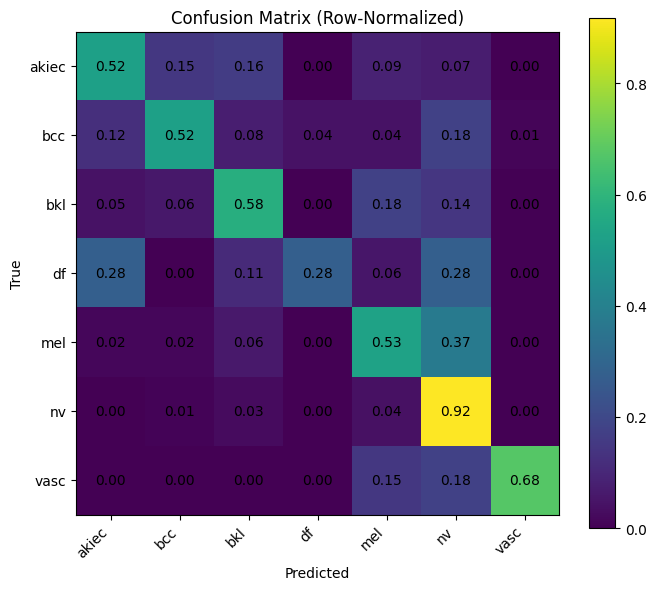

In [ ]:
cm = confusion_matrix(y_true, y_pred)
cm_norm = cm / np.maximum(cm.sum(axis=1, keepdims=True), 1)

plt.figure(figsize=(7, 6))
plt.imshow(cm_norm)
plt.colorbar()
plt.xticks(range(len(classes)), classes, rotation=45, ha="right")
plt.yticks(range(len(classes)), classes)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix (Row-Normalized)")

for i in range(cm_norm.shape[0]):
    for j in range(cm_norm.shape[1]):
        plt.text(j, i, f"{cm_norm[i, j]:.2f}", ha="center", va="center")

plt.tight_layout()
plt.show()


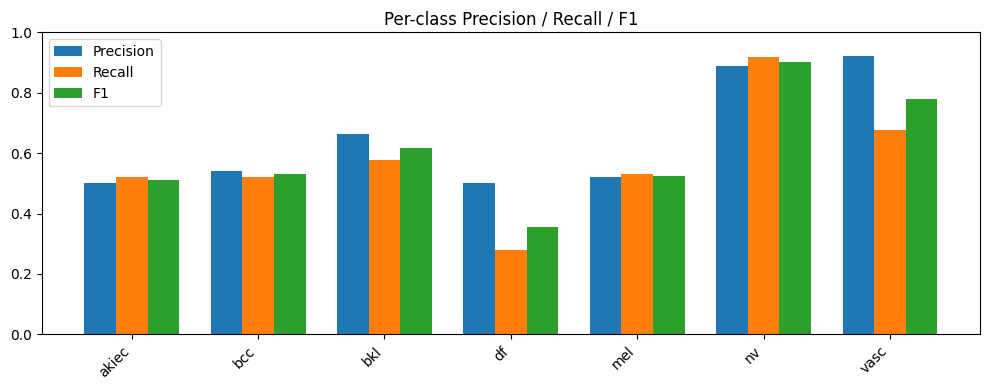

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_fscore_support

prec, rec, f1, sup = precision_recall_fscore_support(
    y_true, y_pred, labels=np.arange(len(classes)), zero_division=0
)

x = np.arange(len(classes))
w = 0.25

plt.figure(figsize=(10, 4))
plt.bar(x - w, prec, width=w, label="Precision")
plt.bar(x,     rec,  width=w, label="Recall")
plt.bar(x + w, f1,   width=w, label="F1")

plt.xticks(x, classes, rotation=45, ha="right")
plt.ylim(0, 1.0)
plt.title("Per-class Precision / Recall / F1")
plt.legend()
plt.tight_layout()
plt.show()


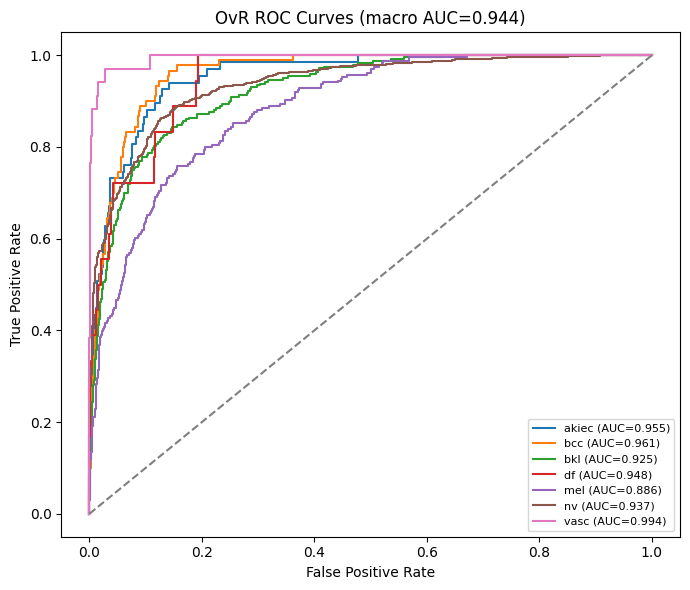

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc

K = len(classes)
y_true_1hot = label_binarize(y_true, classes=np.arange(K))

plt.figure(figsize=(7, 6))

aucs = []
for c in range(K):
    fpr, tpr, _ = roc_curve(y_true_1hot[:, c], y_prob[:, c])
    a = auc(fpr, tpr)
    aucs.append(a)
    plt.plot(fpr, tpr, label=f"{classes[c]} (AUC={a:.3f})")

plt.plot([0, 1], [0, 1], linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title(f"OvR ROC Curves (macro AUC={np.mean(aucs):.3f})")
plt.legend(fontsize=8)
plt.tight_layout()
plt.show()


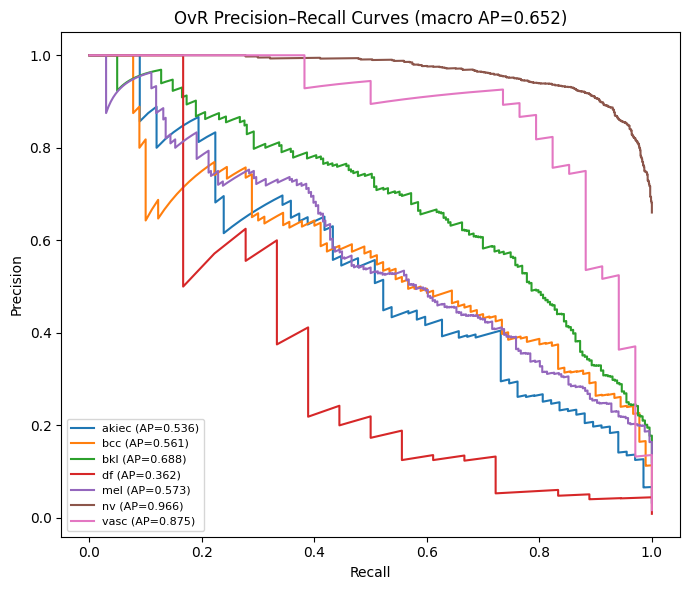

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, average_precision_score
from sklearn.preprocessing import label_binarize

K = len(classes)
y_true_1hot = label_binarize(y_true, classes=np.arange(K))

plt.figure(figsize=(7, 6))

aps = []
for c in range(K):
    p, r, _ = precision_recall_curve(y_true_1hot[:, c], y_prob[:, c])
    ap = average_precision_score(y_true_1hot[:, c], y_prob[:, c])
    aps.append(ap)
    plt.plot(r, p, label=f"{classes[c]} (AP={ap:.3f})")

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title(f"OvR Precision–Recall Curves (macro AP={np.mean(aps):.3f})")
plt.legend(fontsize=8)
plt.tight_layout()
plt.show()


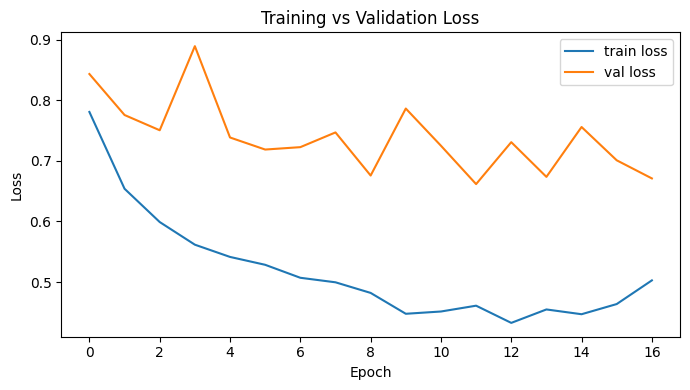

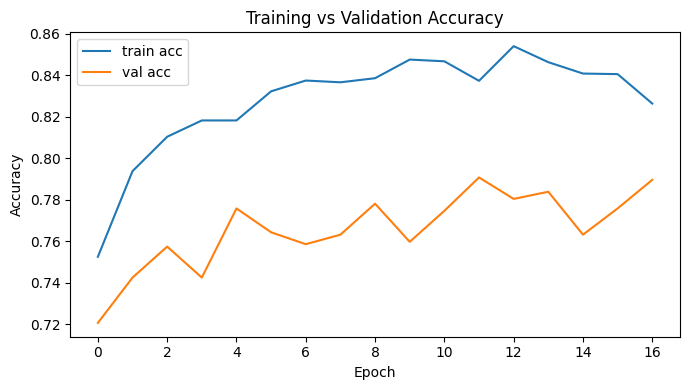

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(7, 4))
plt.plot(history.history["loss"], label="train loss")
plt.plot(history.history["val_loss"], label="val loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss")
plt.legend()
plt.tight_layout()
plt.show()

plt.figure(figsize=(7, 4))
plt.plot(history.history["acc"], label="train acc")
plt.plot(history.history["val_acc"], label="val acc")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Training vs Validation Accuracy")
plt.legend()
plt.tight_layout()
plt.show()
